In [1]:
from src.utils.visualization import plot_scatter, read_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os, json, pickle, sys
from scipy.stats import gaussian_kde
import seaborn as sns
from pathlib import Path
plt.rcParams['font.size'] = 13
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
col_frac   = [f'FR_{x}' for x in 'ABCDE']

In [2]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

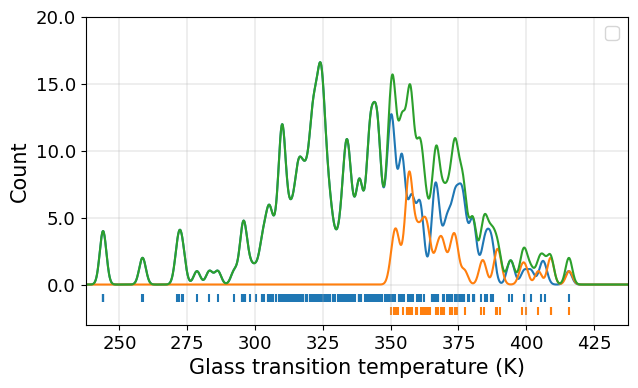

In [3]:
# TG histogram
cmap = plt.get_cmap('viridis')
#df = pd.read_csv('./data/fpolymers_230823.csv')
train_df = pd.read_csv('./data/fpolymers_230823.tg.train.csv')
test_df = pd.read_csv('./data/fpolymers_230823.tg.test.csv')
f, ax = plt.subplots(1,1,figsize=(7,4))
ax.grid(lw=0.3)
x = np.linspace(225, 475, 2000)
ax.set_xlim([237.5,437.5])
train_tgs = train_df.TG + 273.15
test_tgs = test_df.TG + 273.15
g1 = gaussian_kernel(train_tgs, 3)
g2 = gaussian_kernel(test_tgs, 3)
g3 = gaussian_kernel(np.hstack([train_tgs, test_tgs]), 3)
ax.plot(x, g1(x) )
ax.scatter(train_tgs, [-1]*len(train_tgs), marker='|')
ax.plot(x, g2(x) )
ax.scatter(test_tgs, [-2]*len(test_tgs), marker='|')
ax.plot(x, g3(x) )
#sns.histplot(train_df.TG + 273.15, bins=x, alpha=0.6, label=f'Train data ({len(train_df.TG)})', ax=ax, zorder=10)
#sns.histplot(test_df.TG + 273.15, bins=x, alpha=0.6, label=f'Test data ({len(test_df.TG)})', ax=ax, zorder=15)
#sns.histplot(np.hstack([train_df.TG, test_df.TG]) + 273.15, bins=x, alpha=1, label=f'Test data ({len(test_df.TG)})', ax=ax, zorder=5)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Glass transition temperature (K)', fontsize=15)
#ax.legend(loc='upper left', fontsize=12)
h, l = ax.get_legend_handles_labels()
ax.legend(h[1::2], l[1::2])
ax.set_yticks([-3.5, 0, 5, 10, 15, 20])
ax.set_ylim([-3, 20])
f.savefig(Path('../../figs/tg_count_kde.pdf').expanduser())

In [27]:
df[(df == 'CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C').sum(1) != 0]

,ID,Name,CAS_A,CAS_B,CAS_C,CAS_D,CAS_E,SMILES_A,SMILES_B,SMILES_C,...,FR_A,FR_B,FR_C,FR_D,FR_E,ES,DC,TG,MW,TGA_0.01
59,FA-00180,0061_PF-IBNMA-CO-5,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,2.0,5.0,0.0,1.0,2.0,NaN,1.96,135.80,56513.0,141.05
60,FA-00182,0062_PF-IBNMA-CO-3,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,2.0,3.0,2.0,1.0,2.0,NaN,1.72,135.84,56450.0,151.48
61,FA-00183,0063_PF-IBNMA-CO-1,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,2.0,1.0,4.0,1.0,2.0,NaN,2.19,110.26,49009.0,115.81
215,FA-00355,157_IBNMA-442,45115-53-5,7534-94-3,80-62-6,79-41-4,868-77-9,CC(=C)C(=O)OCC(C(F)(F)F)(F)F,CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C,COC(=O)C(C)=C,...,NaN,4.0,4.0,NaN,2.0,NaN,1.84,100.50,62769.0,134.18


In [15]:
np.median(np.hstack([train_df.TG.values, test_df.TG.values])) + 273.15, np.mean(np.hstack([train_df.TG.values, test_df.TG.values])) + 273.15

(344.825, 342.4624489795918)

- molar mass

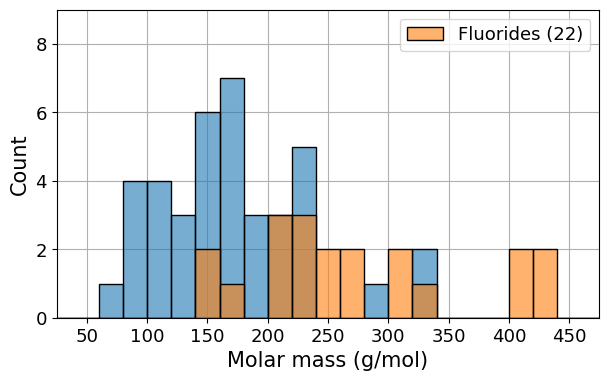

In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
smiles = np.unique(df[col_smiles].values.reshape(-1))
f_mask = np.array(['F' in s for s in smiles])
mol_wts = np.array([Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in smiles])

f, ax = plt.subplots(1,1,figsize=(7,4))
x = np.linspace(0,600,31)
sns.histplot(mol_wts[~f_mask], ax=ax, bins=x, alpha=0.6, zorder=20, label=f'Non-fluorides ({np.sum(~f_mask)})')
sns.histplot(mol_wts[f_mask], ax=ax, bins=x, alpha=0.6, zorder=20, label=f'Fluorides ({np.sum(f_mask)})')
ax.grid()
ax.set_yticks([0,2,4,6,8])
ax.set_xlim([25,475])
ax.set_ylim([0,9])
h, l = ax.get_legend_handles_labels()
ax.legend(h[1::2], l[1::2])
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Molar mass (g/mol)', fontsize=15)

f.savefig(Path('./figs/mw_count.pdf').expanduser())

In [20]:
se = df.SMILES_E.values
for s in np.unique(se):
    print(s, np.sum(s == se))

CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 35
CC(=C)C(=O)OCCO 294
OCCOC(=O)C=C 7


22 39 61


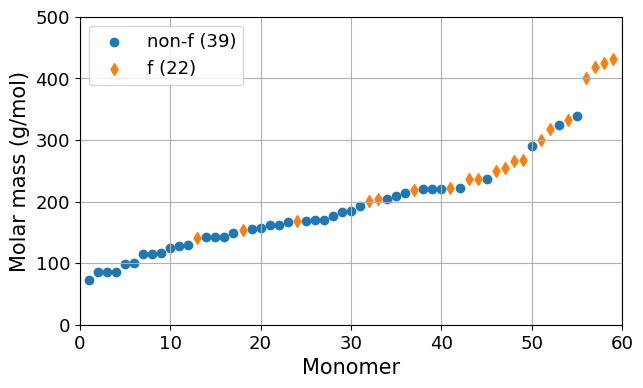

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors

df = pd.read_csv('./data/fpolymers_221123.csv')
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
smiles = np.unique(df[col_smiles].values.reshape(-1))
#smiles = np.unique(np.vstack([train_df[col_smiles].values, test_df[col_smiles].values]).reshape(-1))
#smiles = np.unique(df[col_smiles].values.reshape(-1))
f_mask = np.array(['F' in s for s in smiles])
mol_wts = np.array([Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in smiles])

f, ax = plt.subplots(1,1,figsize=(7,4))
x = np.argsort(mol_wts)
_mol_wts = mol_wts[x]
f_mask = np.array(['F' in smiles[i] for i in x])
print(np.sum(f_mask), np.sum(~f_mask), len(smiles))
ax.scatter(np.where(~f_mask)[0]+1, _mol_wts[~f_mask], marker='o', label=f'non-f ({np.sum(~f_mask)})')
ax.scatter(np.where(f_mask)[0]+1, _mol_wts[f_mask], marker='d', label=f'f ({np.sum(f_mask)})')
ax.grid()
#ax.set_yticks([0,2,4,6,8])
#ax.set_xlim([25,475])
#ax.set_ylim([0,9])
h, l = ax.get_legend_handles_labels()
ax.legend(loc='upper left')
ax.set_xlabel('Monomer', fontsize=15)
ax.set_ylabel('Molar mass (g/mol)', fontsize=15)
ax.set_ylim([0,500])
ax.set_xlim([0,60])

f.savefig(Path('./figs/mw_order.pdf').expanduser())

- Number of monomers

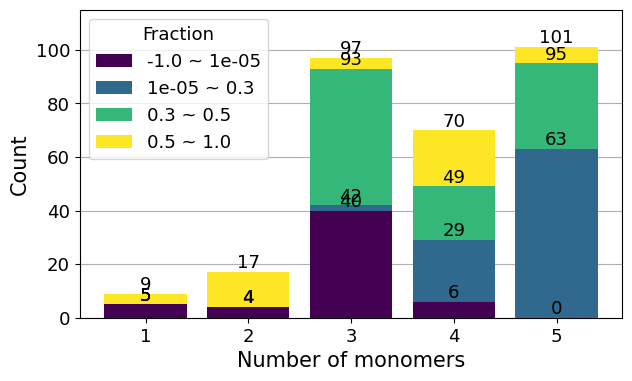

In [16]:
col_smiles = [f'SMILES_{x}' for x in 'ABCDE']
col_weights = [f'FR_{x}' for x in 'ABCDE']
train_df['isTrain'] = True
test_df['isTrain'] = False
df = pd.concat([train_df, test_df])
isFluo = []
fracFluo = []
numMono = []
isTrain = []
for id, row in df.iterrows():
    ws = row[col_weights].fillna(0).values
    m  = ws != 0
    ss = row[col_smiles].values[m]
    isFluo.append(np.sum(['F' in s for s in ss]))
    fracFluo.append(np.sum([w for s, w in zip(ss, ws[m]) if 'F' in s]) / np.sum(ws))
    numMono.append(np.sum(m))
    isTrain.append(row.isTrain)
isFluo   = np.array(isFluo)
fracFluo = np.array(fracFluo)
fracFluo[np.isnan(fracFluo)] = 0
numMono  = np.array(numMono)
isTrain  = np.array(isTrain)

ys = []
bins = np.array([-1,1e-5, 0.3, 0.5, 1])
for i in range(1,6):
    y, _ = np.histogram(fracFluo[numMono == i], bins=bins)
    ys.append(y)
labels = [f'{b1} ~ {b2}' for b1, b2 in zip(bins[:-1], bins[1:])]
x = np.array([1,2,3,4,5])
z = np.array([0,0,0,0,0])
f, ax = plt.subplots(1,1,figsize=(7,4))
for i, y in enumerate(np.array(ys).T):
    bars = ax.bar(x, y, bottom=z, color=plt.get_cmap('viridis')(i/(len(bins)-2)), label=labels[i], zorder=10)
    ax.bar_label(bars, zorder=15)
    z += y
ax.legend(loc='upper left',title='Fraction')
ax.set_xlabel('Number of monomers', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_ylim([0,115])
ax.grid(axis='y', zorder=0)
f.savefig(Path('./figs/monomer_count.pdf').expanduser())


## results

- base code

In [3]:
def get_output(root, tag, summary=False, fmt='n_{:03d}', epoch='best',
               dataset=['train','valid','test'], verbose=False):
    output = {ds:[] for ds in dataset}
    path = os.path.join(root, tag)
    if not os.path.isdir(path):
        return output
    for i in range(100):
        dn = os.path.join(path, fmt.format(i))
        for ds in dataset:
            dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
            if not os.path.isfile(dfn): 
                continue
            with open(dfn, 'rb') as f:
                ids, tgts, preds = pickle.load(f)
            o = np.argsort(ids)
            ids = ids[o]
            tgts = tgts[o]
            preds = preds[o]
            output[ds].append([ids, tgts, preds])
    if verbose:
        ps =  [f'{tag:8s} //' + ''.join([f'{ds:>12} (R2/RMSE/MAE) //' for ds in dataset])]
        ps += [f'Fold: {k:2d} // ' for k in range(len(output['train']))]
        ps += ['AVG:     // ']
        ps += ['STD:     // ']
        ps += ['ALL:     // ' + '        /'*3 + '/ ']
        for i, (ds, d1) in enumerate(output.items()):
            ms = []
            for j, (_, t, p) in enumerate(d1):
                ms.append([r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p)])
                ps[j+1] += '{:7.3f} / {:6.2f} / {:6.2f} // '.format(*ms[-1])
            avg = np.mean(ms, axis=0)
            std = np.std(ms, axis=0)
            ps[-3] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(*avg)
            ps[-2] += ' ±{:5.3f} / ±{:5.2f} / ±{:5.2f} // '.format(*std)
            if ds == 'valid':
                t, p = np.vstack([np.hstack([t, p]) for _, t, p in d1]).T
                ps[-1] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p))
            elif ds == 'test':
                t = d1[0][1]
                p = np.median(np.hstack([p for _, t, p in d1]), axis=1)
                ps[-1] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p))
        print(ps[0])
        print('-'*len(ps[1]))
        if not summary:
            for p in ps[1:-3]:
                print(p)
            print('-'*len(ps[1]))
        print(ps[-3])
        print(ps[-2])
        print(ps[-1])
    return output

In [80]:
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/scratch'
scratch = get_output(os.path.join(root, 'graph'), 'dual_cg', verbose=True)
print()
scratch_sing = get_output(os.path.join(root, 'graph'), 'sing_cg', verbose=True)
print()
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3'
finetune = get_output(os.path.join(root, 'graph'), 'dual_cg', verbose=True)
print()
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3'
finetune_sing = get_output(os.path.join(root, 'graph'), 'sing_cg', verbose=True)

dual_cg  //       train (R2/RMSE/MAE) //       valid (R2/RMSE/MAE) //        test (R2/RMSE/MAE) //
---------------------------------------------------------------------------------------------------
Fold:  0 //   0.875 /  10.98 /   5.72 //   0.758 /  13.10 /   9.77 //   0.285 /  14.90 /  10.81 // 
Fold:  1 //   0.893 /  10.04 /   5.15 //   0.540 /  19.08 /  13.06 //   0.591 /  11.27 /   8.80 // 
Fold:  2 //   0.864 /  10.75 /   5.65 //   0.662 /  19.25 /  12.88 //   0.573 /  11.51 /   8.69 // 
Fold:  3 //   0.852 /  11.54 /   5.88 //   0.774 /  14.60 /  10.06 //   0.694 /   9.74 /   6.84 // 
Fold:  4 //   0.903 /   9.35 /   5.26 //   0.622 /  18.88 /  12.58 //   0.192 /  15.85 /  10.12 // 
---------------------------------------------------------------------------------------------------
AVG:     //   0.877 /  10.53 /   5.53 //   0.671 /  16.98 /  11.67 //   0.467 /  12.65 /   9.05 // 
STD:     //  ±0.019 / ± 0.76 / ± 0.28 //  ±0.087 / ± 2.60 / ± 1.44 //  ±0.194 / ± 2.32 / ± 1.36 // 
A

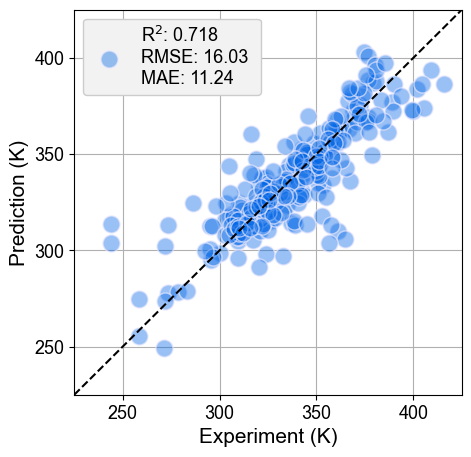

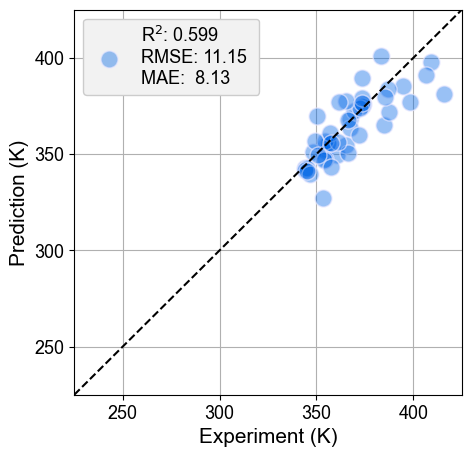

In [495]:
vt, vp = np.hstack([[s[1],s[2]] for s in finetune_sing['valid']]) + 273.15
tt, tp = np.median([[s[1],s[2]] for s in finetune_sing['test']], axis=0) + 273.15
xrange = [225, 425]
for lbl, t, p in zip(['valid','test'], [vt, tt], [vp, tp]):
    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    plot_scatter(ax, t, p, xrange=xrange, s=150, edgecolor=[0.9,0.9,1,0.7], facecolor=[0,0.4,0.9,0.4], lw=1)
    ax.set_xticks([250 + i*50 for i in range(4)])
    ax.set_yticks([250 + i*50 for i in range(4)])
    fn = Path(f'./figs/finetune_sing_graph_cg_{lbl}.pdf').expanduser()
    ax.set_ylabel('Prediction (K)', fontsize=15)
    ax.set_xlabel('Experiment (K)', fontsize=15)
    f.savefig(fn)

Text(0.5, 0, 'Experiment (K)')

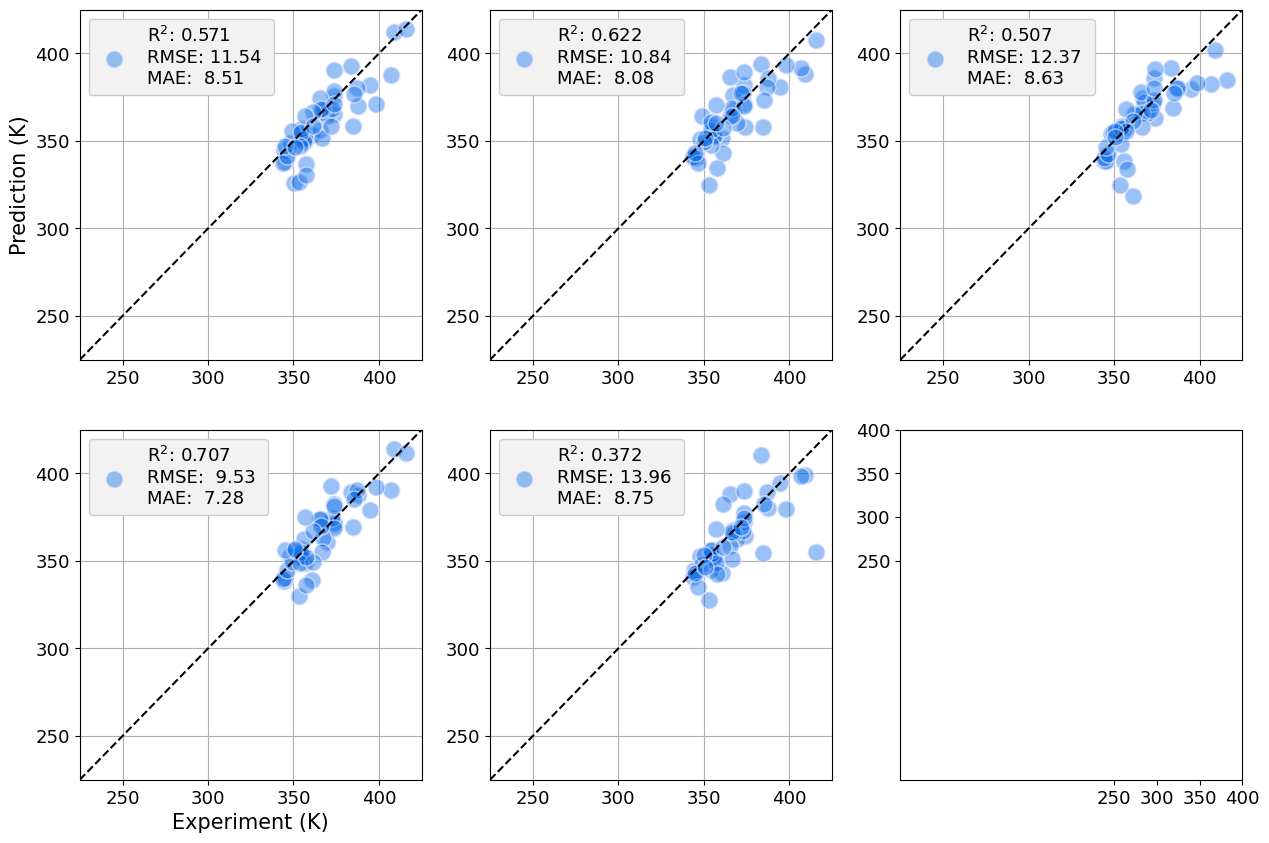

In [54]:
vs = [np.array([s[1],s[2]]).squeeze()+273.15 for s in finetune['valid']]
ts = [np.array([s[1],s[2]]).squeeze()+273.15 for s in finetune['test']]
tids = [s[0] for s in finetune['test']]
xrange = [225, 425]
f, axs = plt.subplots(2,3, figsize=(15, 10))
axs = axs.reshape(-1)
for (tt, tp), ax in zip(ts, axs[:-1]):
    plot_scatter(ax, tt, tp, xrange=xrange, s=150, edgecolor=[0.9,0.9,1,0.7], facecolor=[0,0.4,0.9,0.4], lw=1)
for ax in axs:
    ax.set_xticks([250 + i*50 for i in range(4)])
    ax.set_yticks([250 + i*50 for i in range(4)])
#    fn = Path(f'./figs/finetune_sing_graph_cg_{lbl}.pdf').expanduser()
axs[0].set_ylabel('Prediction (K)', fontsize=15)
axs[3].set_xlabel('Experiment (K)', fontsize=15)
#    f.savefig(fn)

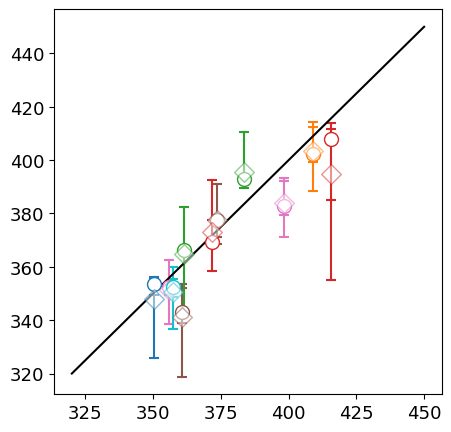

In [6]:
target, pred = np.array(ts).transpose(1,0,2)
target = target[0]
f, ax = plt.subplots(1,1,figsize=(5,5))
cmap = plt.get_cmap('tab10')
for j, (t, p) in enumerate(zip(target, pred.T)):
    v = np.var(p)
    if v < 50: continue
    i = np.argsort(p)
    ax.scatter([t]*5, p, marker='_', color=cmap(j%10), s=50)
    ax.plot([t,t], [p[i[0]], p[i[-1]]], color=cmap(j%10))
    ax.scatter(t, p[i[2]], facecolor=[1,1,1], marker='o', edgecolor=cmap(j%10), zorder=10, s=100)
    ax.scatter(t, np.mean(p), alpha=0.5, facecolor=[1,1,1], marker='D', edgecolor=cmap(j%10), zorder=10, s=100)
ax.plot([320, 450],[320,450], color=[0,0,0])

- ensemble error for test set

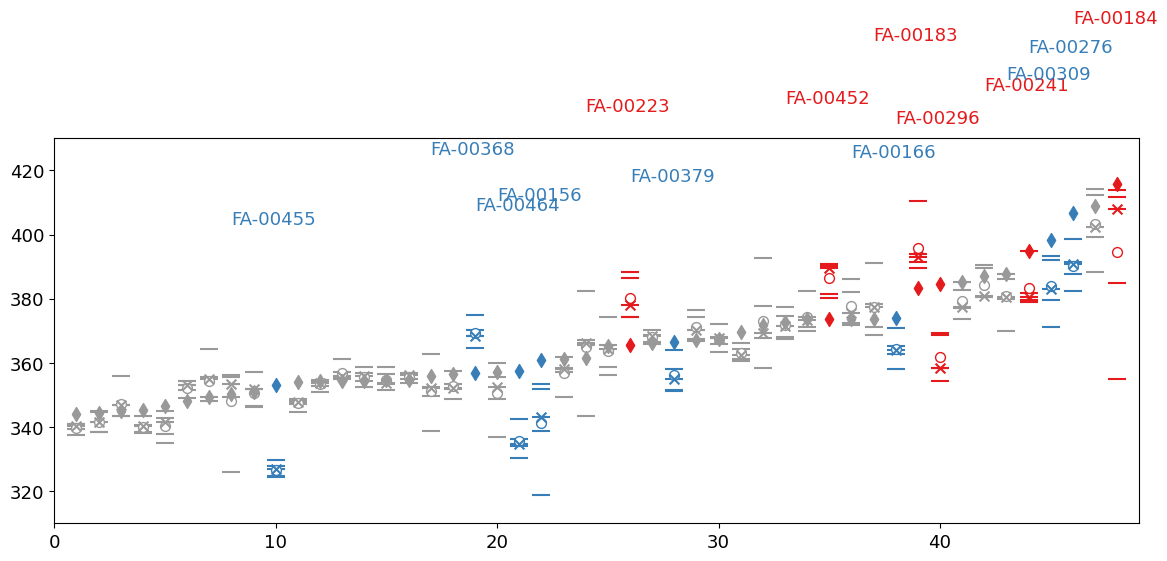

In [77]:
target, pred = np.array(ts).transpose(1,2,0)
target = target[:,0]
o = np.argsort(target)
f, ax = plt.subplots(1,1,figsize=(14,5))
cmap = plt.get_cmap('Set1')
for x, i in enumerate(o):
    t = target[i]
    p = pred[i]
    m = np.median(p)
    a = np.mean(p)
    if np.abs(t - m) < 9 and np.abs(t - a) < 9:
        j = 8
    elif np.abs(m - a) > 2:
        j = 0
    else:
        j = 1
    c = cmap(j)
    ax.scatter([x+1]*5,p,color=c, marker='_', s=150)
    ax.scatter(x+1, t,color=c, marker='d', s=50, zorder=10)
    ax.scatter(x+1, a, color=c, marker='o', facecolor=[1,1,1], s=50)
#    ax.scatter(x+1, m, color=c, marker='s', facecolor=[1,1,1], s=20)
    ax.scatter(x+1, m, color=c, marker='x', s=50)
    if j != 8:
        ax.text(x-1, np.max([t, np.max(p)])+50, tids[0][i], color=c)
ax.set_xlim([0,49])
ax.set_ylim([310, 430])
fn = Path('./figs/scatter_test_all.pdf')
f.savefig(fn)

In [76]:
#np.where(tids[0] == 'FA-00455')
pred[42], target[42]

(array([326.80884, 324.8396 , 324.57977, 329.69998, 327.8172 ],
       dtype=float32),
 353.19)

In [386]:
pred.T[np.argsort(np.var(pred, axis=0))[-1]]

array([413.8163 , 407.92004, 384.9201 , 411.74115, 355.00488],
      dtype=float32)

In [57]:
roots = [
    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/scratch_e1',
#    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e1_300',
    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e1_500',
    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/scratch',
#    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/test/ft_e3_500_s0.2',
#    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3_300',
    '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/cv_5/finetune_e3_500',
]
tags = [
#    'mol/dual_dnn',
#    'mol/sing_dnn',
#    'graph/dual_cg',
#    'graph/dual_tf',
#    'graph/sing_cg',
#    'graph/sing_tf',
    'concat/dual_cg',
#    'concat/dual_tf',
    'concat/sing_cg',
#    'concat/sing_tf',
]
outputs = {}
for tag in tags:
    t1, t2 = tag.split('/')
    for root in roots:
        out = get_output(root, tag, verbose=True, summary=False)
        outputs['/'.join([root.split('/')[-1], tag])] = out
        print()
    print()

concat/dual_cg //       train (R2/RMSE/MAE) //       valid (R2/RMSE/MAE) //        test (R2/RMSE/MAE) //
---------------------------------------------------------------------------------------------------
Fold:  0 //   0.886 /  10.45 /   7.21 //   0.570 /  17.46 /  11.77 //   0.420 /  13.42 /  10.52 // 
Fold:  1 //   0.859 /  11.52 /   7.50 //   0.539 /  19.09 /  12.53 //   0.542 /  11.93 /   7.91 // 
Fold:  2 //   0.841 /  11.62 /   8.01 //   0.496 /  23.52 /  16.99 //   0.322 /  14.52 /  11.55 // 
Fold:  3 //   0.837 /  12.12 /   7.65 //   0.741 /  15.64 /  12.24 //   0.548 /  11.85 /   9.02 // 
Fold:  4 //   0.916 /   8.68 /   6.20 //   0.505 /  21.61 /  13.18 //   0.324 /  14.49 /   9.68 // 
---------------------------------------------------------------------------------------------------
AVG:     //   0.868 /  10.88 /   7.32 //   0.570 /  19.46 /  13.34 //   0.431 /  13.24 /   9.73 // 
STD:     //  ±0.030 / ± 1.22 / ± 0.61 //  ±0.089 / ± 2.82 / ± 1.88 //  ±0.099 / ± 1.17 / ± 1.25

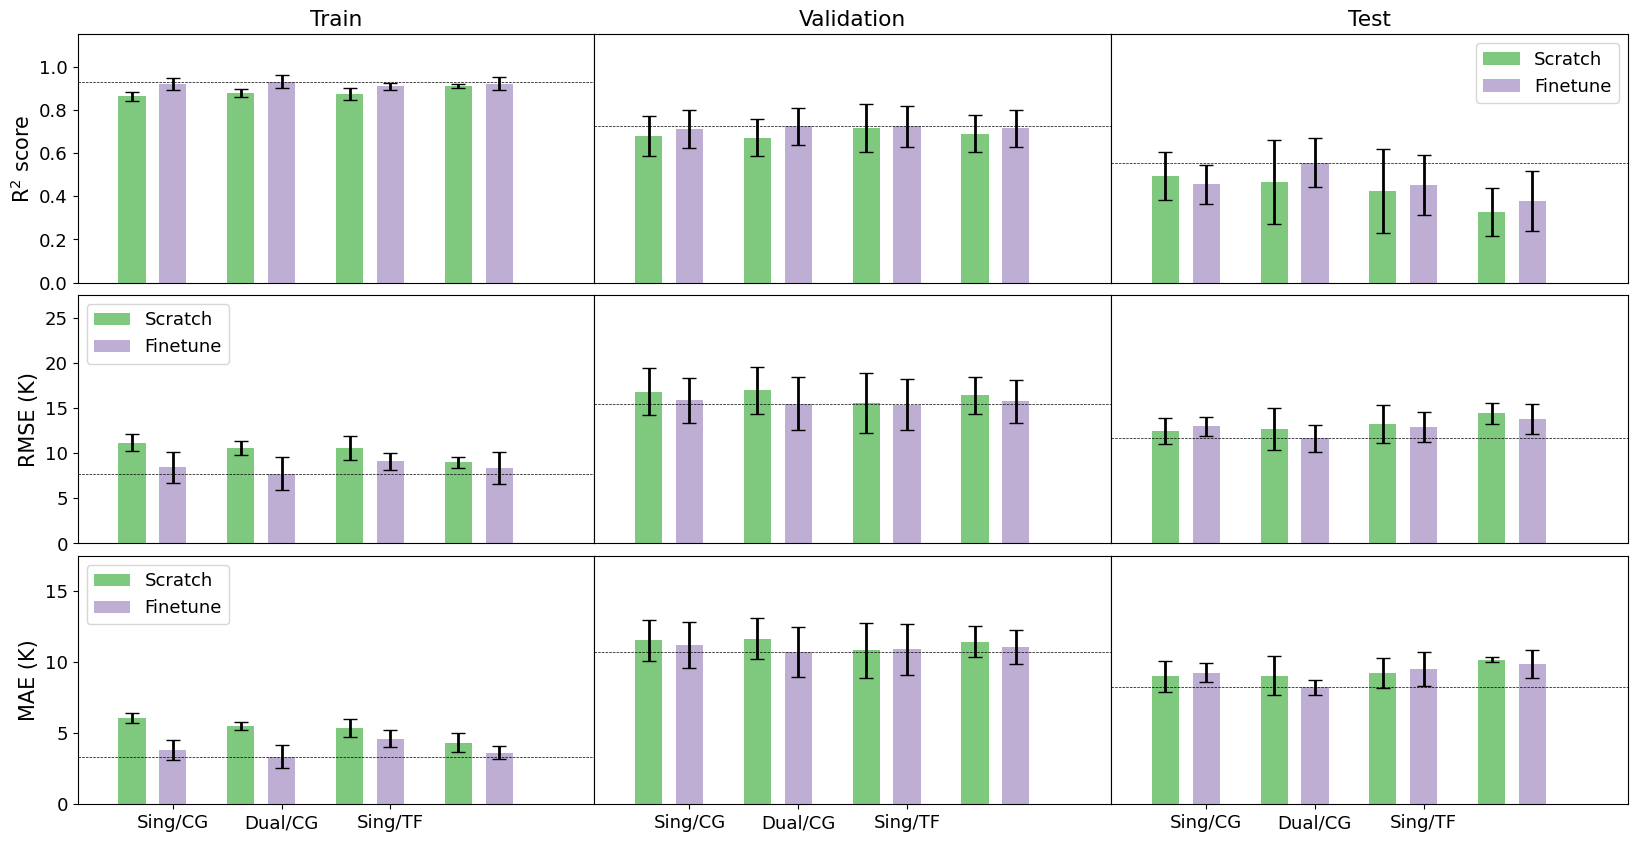

In [120]:
f, axs = plt.subplots(3,3,figsize=(20, 10))
cmap = plt.get_cmap('Accent')
ts = ['scratch','finetune_e3']
ms = ['sing_cg.json','dual_cg.json','sing_tf.json','dual_tf.json']
ds = ['train','valid','test']
ticks = []
for k, out in outputs.items():
    t, _, m = k.split('/')
    for d, cvs in out.items():
        i1 = ts.index(t)
        i2 = ms.index(m)
        i3 = ds.index(d)
        errs = []
        for _, tgt, pred in cvs:
            r2 = r2_score(tgt, pred)
            rmse = np.sqrt(mean_squared_error(tgt, pred))
            mae = mean_absolute_error(tgt, pred)
            errs.append([r2, rmse, mae])
        avgs = np.mean(errs, axis=0)
        stds = np.std(errs, axis=0)
        x = i1*0.75 + i2*2
        for ax, avg, std in zip(axs, avgs, stds):
            if i2 == 0:
                ax[i3].bar(x, avg, color=cmap(i1), width=0.5, label=['Scratch','Finetune','Scratch+NewData'][i1])
            else:
                ax[i3].bar(x, avg, color=cmap(i1), width=0.5)
            ax[i3].errorbar(x, avg, yerr=std, color=[0,0,0], capsize=5, lw=2)
            if i1 == 1 and i2 == 1:
                ax[i3].axhline(avg, ls='--', lw=0.5, color=[0,0,0])

for ax in axs[:2].reshape(-1):
    ax.set_xticks([])
for ax in axs[2]:
    ax.set_xticks([0.75, 2.75, 4.75, 8.75], ['Sing/CG','Dual/CG','Sing/TF','Dual/TF'])
for ax in axs.T[1:].reshape(-1):
    ax.set_yticks([])
for ax in axs.reshape(-1):
    ax.set_xlim([-1, 8.5])
axs[0,0].set_title('Train')
axs[0,1].set_title('Validation')
axs[0,2].set_title('Test')

axs[0,2].legend(loc='upper right')
axs[1,0].legend(loc='upper left')
axs[2,0].legend(loc='upper left')

axs[0,0].set_ylabel('R$^2$ score', fontsize=15)
axs[1,0].set_ylabel('RMSE (K)', fontsize=15)
axs[2,0].set_ylabel('MAE (K)', fontsize=15)
for ax in axs[0]:
    ax.set_ylim([0,1.15])
for ax in axs[1]:
    ax.set_ylim([0, 27.5])
for ax in axs[2]:
    ax.set_ylim([0, 17.5])
f.subplots_adjust(wspace=0, hspace=0.05)
#for ax in axs:
#    ax.set_xlim([2.5+2/3-4.5, 20.5+2/3+4.5])

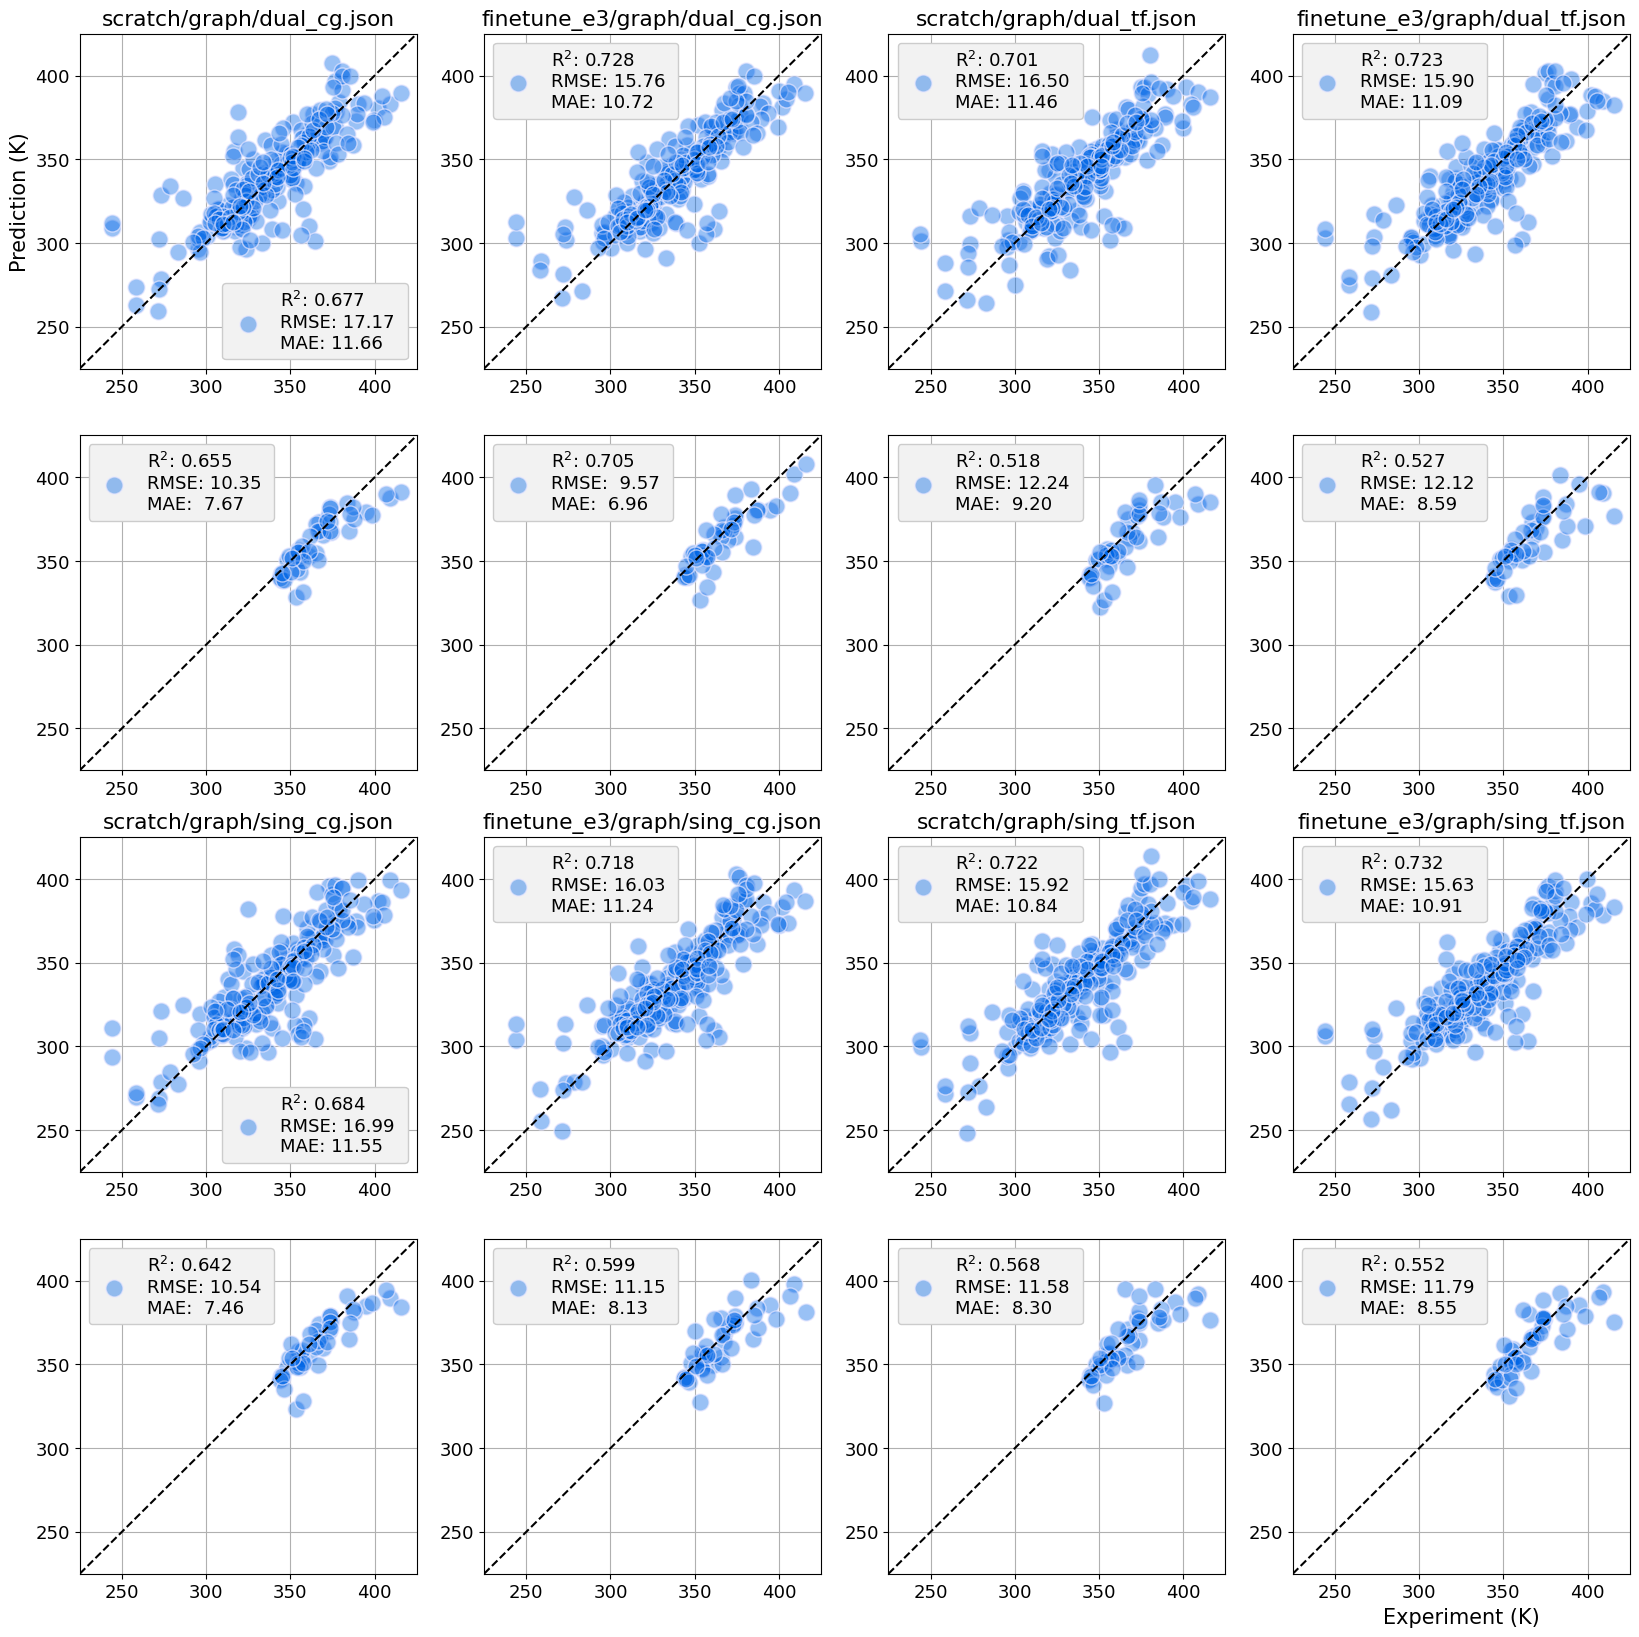

In [133]:
f, axs = plt.subplots(4,4,figsize=(20,20))
axs = np.hstack([axs[:2], axs[2:]]).T
xrange = [225, 425]
for ax, (k, out) in zip(axs, outputs.items()):
    vt, vp = np.hstack([[s[1],s[2]] for s in out['valid']]) + 273.15
    tt, tp = np.median([[s[1],s[2]] for s in out['test']], axis=0) + 273.15
    ax[0].set_title(k)
    for _ax, lbl, t, p in zip(ax, ['valid','test'], [vt, tt], [vp, tp]):
        plot_scatter(_ax, t, p, xrange=xrange, s=150, edgecolor=[0.9,0.9,1,0.7], facecolor=[0,0.4,0.9,0.4], lw=1)
        _ax.set_xticks([250 + i*50 for i in range(4)])
        _ax.set_yticks([250 + i*50 for i in range(4)])
axs[0,0].set_ylabel('Prediction (K)', fontsize=15)
axs[-1,-1].set_xlabel('Experiment (K)', fontsize=15)
fn = Path(f'./figs/scatter_all.pdf').expanduser()
f.savefig(fn)

In [43]:
f, axs = plt.subplots(12,3,figsize=(15,30))
metric = 'MAE'
cmap = plt.get_cmap('Set2')
for i, net in enumerate(['mol','graph','concat']):
    for k, v in scores.items():
        if net not in k: continue
        x = int(k.split('_')[1])
        im = int(k.split('_')[2])-1
        ilg = int(k.split('_')[3])
        ilm = int(k.split('_')[4])
        for j, (ds, data) in enumerate(v.items()):
            vals = []
            for _, ts, ps in data:
                val = []
                for h, (t, p) in enumerate(zip(ts.T, ps.T)):
                    if metric == 'R2':
                        e = r2_score(t, p)
                    elif metric == 'MAE':
                        e = mean_absolute_error(t, p)
                    elif metric == 'RMSE':
                        e = np.sqrt(mean_squared_error(t, p))
                    else:
                        raise ValueError('not supp metric')
                    val.append(e)
                vals.append(val)
            for l, val in enumerate(np.array(vals).T):
                axs[l, j].errorbar(x, np.mean(val), yerr=np.std(val), marker=m, color=cmap(i))
for ax in axs.reshape(-1):
    ax.set_xscale('log')
    ax.set_xlim([1e4, 1e6])
#   ax.set_ylim([0.95, 1.05])
    

(6695, 12)

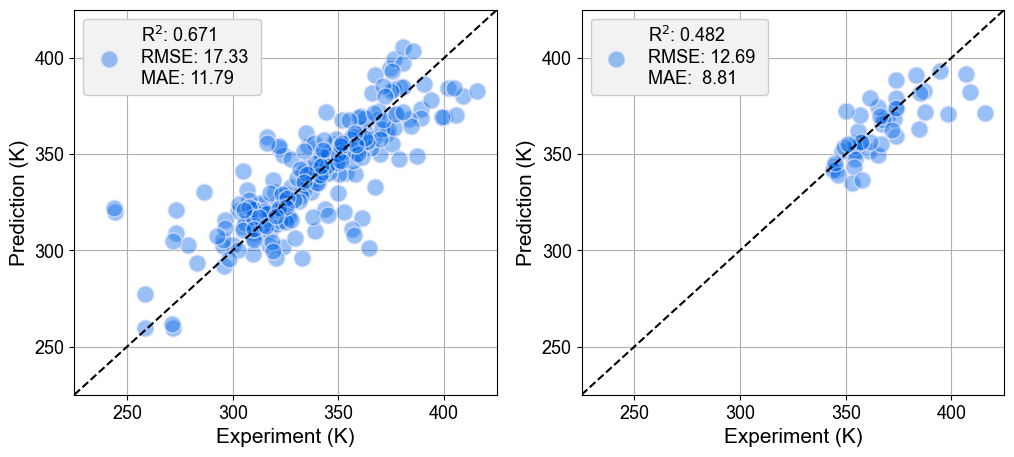

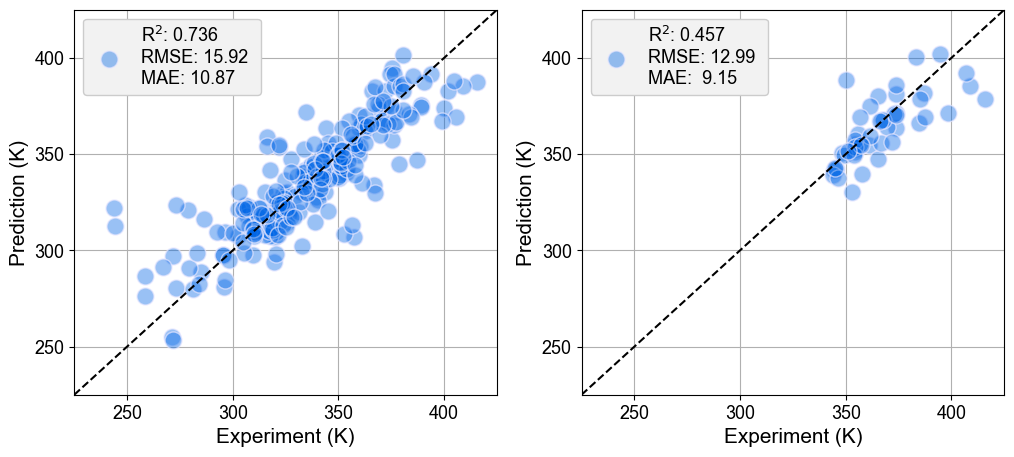

In [51]:

for root in roots:
    out = get_output(root, 'mol', 'sing_dnn', verbose=False, summary=True)

    vt, vp = np.hstack([[s[1],s[2]] for s in out['valid']]) + 273.15
    tt, tp = np.median([[s[1],s[2]] for s in out['test']], axis=0) + 273.15
    xrange = [225, 425]
    f, axs = plt.subplots(1, 2, figsize=(12, 5))
    for lbl, t, p, ax in zip(['valid','test'], [vt, tt], [vp, tp], axs):

#    for lbl, t, p in zip(['valid','test'], [vt, tt], [vp, tp]):
#        f, ax = plt.subplots(1, 1, figsize=(5, 5))
        plot_scatter(ax, t, p, xrange=xrange, s=150, edgecolor=[0.9,0.9,1,0.7], facecolor=[0,0.4,0.9,0.4], lw=1)
        ax.set_xticks([250 + i*50 for i in range(4)])
        ax.set_yticks([250 + i*50 for i in range(4)])
#        fn = Path(f'./figs/finetune_sing_graph_cg_{lbl}.pdf').expanduser()
        ax.set_ylabel('Prediction (K)', fontsize=15)
        ax.set_xlabel('Experiment (K)', fontsize=15)
#        f.savefig(fn)

In [14]:
df.TG.median() + 273.15, df.TG.mean() + 273.15, 350-273.15

(344.46, 341.935, 76.85000000000002)

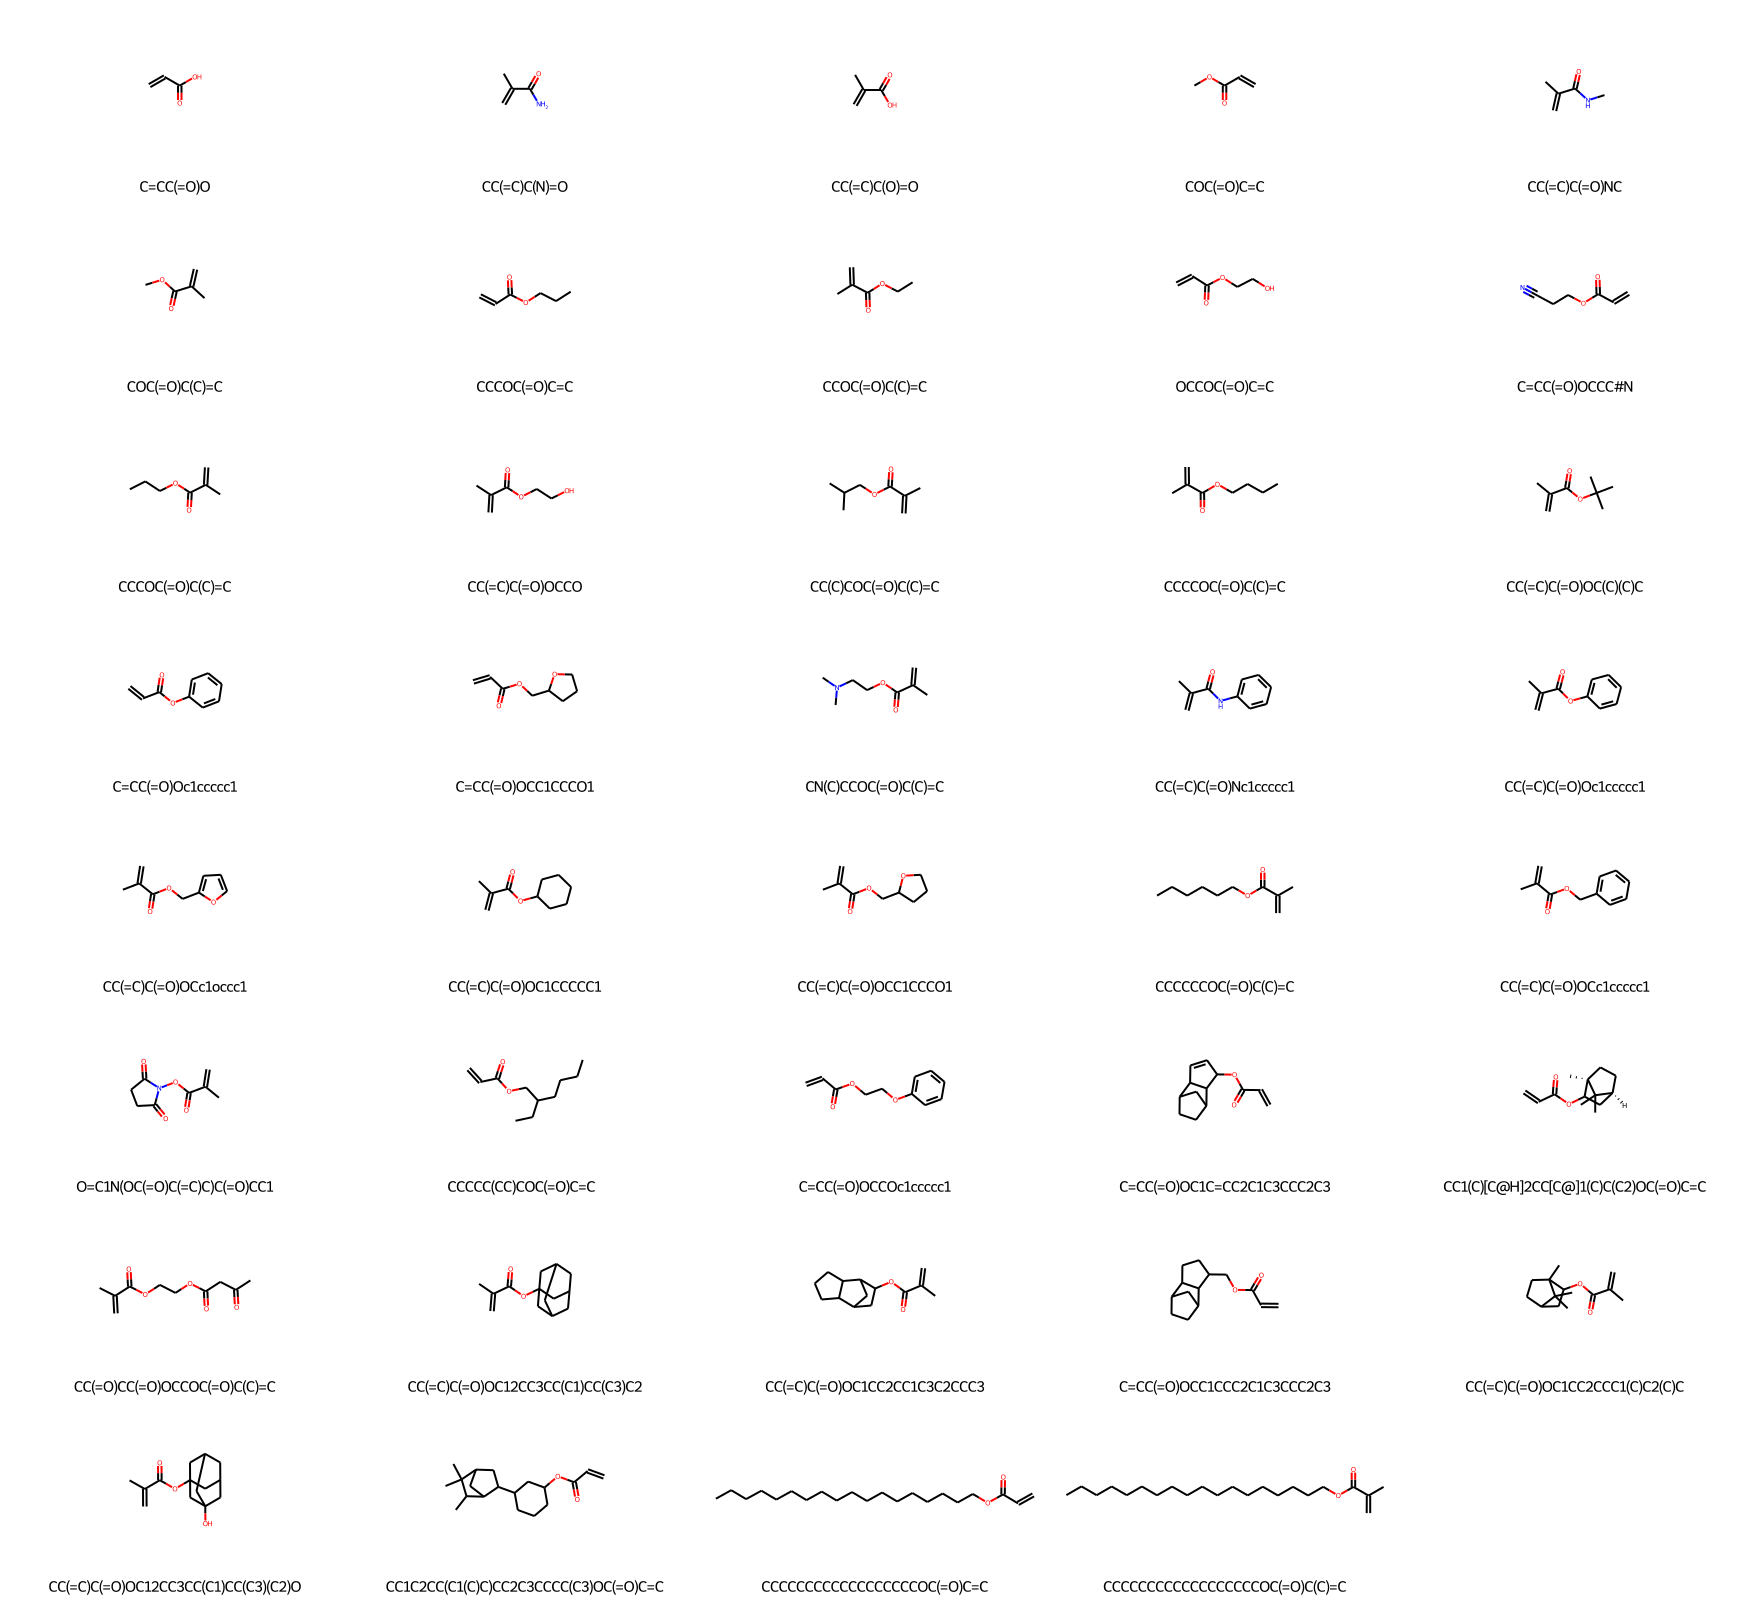

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

df = pd.concat([train_df, test_df])
smiles = np.unique(df[[f'SMILES_{x}' for x in 'ABCDE']].values)
smiles_f = sorted([s for s in smiles if 'F' in s], key=lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
smiles_c = sorted([s for s in smiles if 'F' not in s], key=lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
mol_f = [Chem.MolFromSmiles(s) for s in smiles_f]
mol_c = [Chem.MolFromSmiles(s) for s in smiles_c]
Draw.MolsToGridImage(mol_c, subImgSize=(350,200), molsPerRow=5, legends=smiles_c, useSVG=True)
#Draw.MolsToGridImage(mol_f, subImgSize=(350,200), molsPerRow=5, legends=smiles_f, useSVG=True)

In [ ]:
Draw.MolsToGridImage(mol_c, subImgSize=(300,150))

# make blacklist

In [12]:
from src.utils.dataset import QM9Dataset, FPolyDatasetV2, collate_fn

qd = QM9Dataset()
fd = FPolyDatasetV2()

qd.load('./data/cache_qm9.csv_n0x180fe1f_0x20afd.pkl')
fd.load('./data/cache_fpolymers_230823.tg.train.csv_v2n0xfff_0x380xf5.pkl')

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Setting new attribute : tag
  Setting new attribute : cache_fn
  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Setting new attribute : tag
  Setting new attribute : cache_fn
  Setting new attribute : unique_data


In [23]:
feat_q = collate_fn(qd)[0]
feat_f = collate_fn(fd)[0]

In [31]:
feat_q[0].keys()

dict_keys(['atom_feat', 'bond_feat', 'bond_idx', 'mol_feat', 'graph_idx', 'weight', 'data_idx'])

In [57]:
names = {}
for k in ['atom_feat', 'bond_feat','mol_feat']:
    f0 = feat_q[0][k].numpy().std(0) > 1e-2
    f1 = feat_f[0][k].numpy().std(0) > 1e-2
    f2 = feat_f[1][k].numpy().std(0) > 1e-2
    f3 = np.vstack([feat_f[0][k].numpy(), feat_f[1][k].numpy()]).std(0) > 1e-2
    print(np.sum(f0), np.sum(f1), np.sum(f2), np.sum(f3), np.sum(f0 & f1 & f2), np.sum(f0 & f3))
    print(np.array(getattr(qd, k+'_name'))[~(f0 & f3)])
    names[k] = np.array(getattr(qd, k+'_name'))[~(f0 & f3)].tolist()
with open('blacklist.json','w') as f:
    json.dump(names, f, indent=4)

21 23 21 23 20 21
['block' 'fusion_heat' 'metallic_radius' 'ele_config_d' 'ele_config_f']
5 5 5 5 5 5
[]
296 245 273 277 233 266
['NumRadicalElectrons' 'PEOE_VSA1' 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12'
 'PEOE_VSA13' 'PEOE_VSA14' 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5'
 'PEOE_VSA6' 'PEOE_VSA7' 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10'
 'SMR_VSA2' 'SMR_VSA3' 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7'
 'SMR_VSA8' 'SMR_VSA9' 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11'
 'SlogP_VSA12' 'SlogP_VSA2' 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VSA5'
 'SlogP_VSA6' 'SlogP_VSA7' 'SlogP_VSA8' 'SlogP_VSA9' 'TPSA' 'EState_VSA1'
 'EState_VSA10' 'EState_VSA11' 'EState_VSA2' 'EState_VSA3' 'EState_VSA4'
 'EState_VSA5' 'EState_VSA6' 'EState_VSA7' 'EState_VSA8' 'EState_VSA9'
 'VSA_EState1' 'VSA_EState10' 'VSA_EState2' 'VSA_EState3' 'VSA_EState4'
 'VSA_EState5' 'VSA_EState6' 'VSA_EState7' 'VSA_EState8' 'VSA_EState9'
 'fr_ArN' 'fr_Ar_COO' 'fr_Ar_N' 'fr_Ar_NH' 'fr_Ar_OH' 'fr_C_S' 'fr_HOCCN'
 'fr_Imine' 'fr_N

# Visualization of molecule (skeletal)

In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
df1 = pd.read_csv('./data/fpolymers_230823.tg.train.csv')
df2 = pd.read_csv('./data/fpolymers_230823.tg.test.csv')

In [19]:
mols = []
for i, row in df2.iloc[[5, 17, 33]].iterrows():
    c = Chem.MolFromSmiles('C')
    mol = [Chem.MolFromSmiles(s) if f != 0 else c for s, f in zip(row[col_smiles].values, row[col_frac].values)]
    mols.extend(mol)
    print(row[col_smiles].values)
    print(row[col_frac].values)
img = Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True)
with open('./figs/mols.5.17.33.svg','w') as f:
    f.write(img.data)
#m = Chem.MolFromSmiles('OCc1c(O)nc[nH]1	')
#Draw.MolToImage(m)
#Draw.MolToFile(m, './figs/mols2.svg', imageType='svg')

['CC(=C)C(=O)OCC(C(F)(F)F)(F)F' 'CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C'
 'COC(=O)C(C)=C' 'CC(=C)C(O)=O' 'CC(=C)C(=O)OCCO']
[2.0 3.0 2.0 1.0 2.0]
['CC(=C)C(=O)OCC(C(F)(F)F)(F)F' 'COC(=O)C(C)=C' 'COC(=O)C(C)=C'
 'CC(=C)C(O)=O' 'CC(=C)C(=O)OCCO']
[0.0 0.0 1.0 0.0 0.0]
['CC(=C)C(=O)OCC(C(F)(F)F)(F)F' 'CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C'
 'COC(=O)C(C)=C' 'CC(=C)C(O)=O' 'CC(=C)C(=O)OCCO']
[0.0 4.0 4.0 0.0 2.0]


In [ ]:
idxs = [7,12]
test_smiles = [df2.loc[i, [f'SMILES_{x}' for x in 'ABCDE']].values for i in idxs]
test_frs = [df2.loc[i, [f'FR_{x}' for x in 'ABCDE']].values for i in idxs]
print(np.vstack(test_frs))
mols = [Chem.MolFromSmiles(s) for s in np.vstack(test_smiles).reshape(-1)]
Draw.MolsToGridImage(mols, molsPerRow=5)

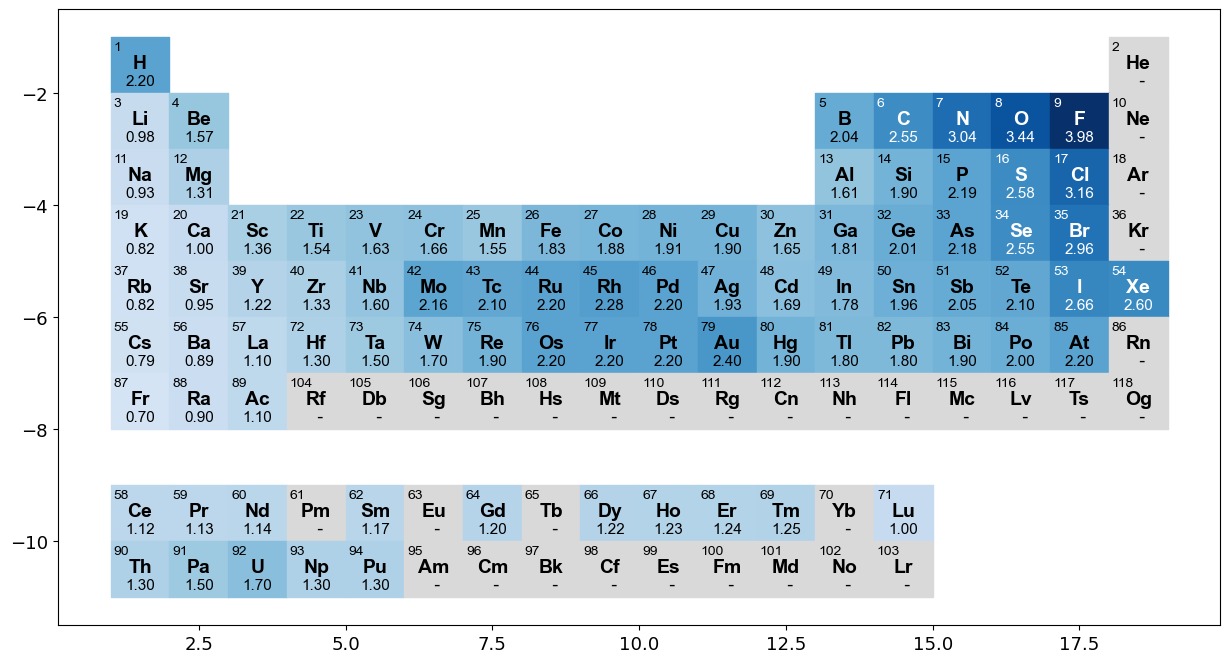

In [138]:
import mendeleev
import matplotlib.pyplot as plt
import matplotlib as mpl
f, ax = plt.subplots(1,1,figsize=(15,8))
cy = 0
#ptable = {}
boxes = []
cmap = mpl.cm.Blues
cmap.set_under([0.85,0.85,0.85])
for i in range(1,119):
    if i not in ptable.keys():
        t = mendeleev.element(i).symbol
        z = mendeleev.element(i).en_pauling
        x = mendeleev.element(i).period
        y = mendeleev.element(i).group_id
        ptable[i] = t, z, x, y
    else:
        t, z, x, y = ptable[i]
    if y == None:
        cy += 1
        y = cy
        x += 3
    else:
        cy = 0       
    if z is None: z = -1
    
    x=-x
#    print(i, x,y)
    ax.fill_between([y, y+1], x, x-1, color=cmap(z/3.98))
    color = [0,0,0]
    if z > 2.5: color = [1,1,1]
    ax.text(y+0.05, x-0.24, str(i), fontsize=10, fontfamily='arial', color=color)
    ax.text(y+0.5, x-0.55,t, fontsize=14, fontweight='bold', fontfamily='arial', color=color, horizontalalignment='center')
    if z < 0:
        ax.text(y+0.5, x-0.85, '-')
    else:
        ax.text(y+0.5, x-0.85, f'{z:.2f}', fontsize=11, fontfamily='arial', color=color, horizontalalignment='center')
f.savefig('./figs/ptable.electronegativity.pdf')


In [81]:
import pickle

TypeError: 'PathCollection' object is not subscriptable